In [167]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

In [168]:
#"review_scores_rating", 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
#               'review_scores_location','review_scores_value'

In [169]:
cols_to_use = ["id", "source", "name", "description", "neighborhood_overview", "host_id", "host_name", "host_since", "host_location",
               "host_about", "host_response_rate", "host_acceptance_rate", "host_is_superhost", "host_verifications", "host_has_profile_pic", 
               "host_identity_verified", "neighbourhood_group_cleansed", "property_type", "room_type", "accommodates", "bathrooms", "bathrooms_text", 
               "bedrooms", "beds", "amenities", "price", "minimum_nights", "maximum_nights", "availability_365", "number_of_reviews",
               "instant_bookable", "calculated_host_listings_count"]

# Sort only according to the columns we want
df= pd.read_csv("./listings.csv", sep = ',', usecols = cols_to_use)

In [172]:
# Function to convert text description of listing to length (characters)
def text_to_len(df: pd.DataFrame, text_columns: list):
    for col in text_columns:
        df.loc[:,col] = df[col].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
    return df

# Relevant for ["name", "description", "neighborhood_overview", "host_about, "host_verifications", "amnenities"]

In [173]:
# Function to convert host_since dates to datetime to instead have a column representing how many days they have been host

def days_as_host(df: pd.DataFrame, date_col: str, reference_date: str):
    reference_date = pd.Timestamp(reference_date)
    df[date_col] = pd.to_datetime(df[date_col]) # Convert to datetime
    
    # Rename "host_since" to "days_as_host"
    df.rename(columns={date_col: 'days_as_host'}, inplace = True)
    
    # Calculate the number of days from reference date
    df['days_as_host'] = (reference_date - df['days_as_host']).dt.days

    return df
# Reference day: 05/09/2024 (since this is when it was last scraped)
# Relevant column: "host_since"

In [174]:
# Function to convert the attributes with "t" and "f" to "True" and "False"

def convert_to_boolean(df: pd.DataFrame, boolean_cols: list):
    for col in boolean_cols:
        df[col] = df[col].replace({'f':False, 't': True})        
    # Removing any listing with NaN values 
    df = df.dropna(subset=boolean_cols)
    return df

In [175]:
# Function to convert the location of the host, to "True/False" if they are in or outside of New York

def is_host_in_NY(df: pd.DataFrame, host_location: str):
    
    # Convert to true or false
    df.loc[:, host_location] = df[host_location].apply(lambda x: True if 'New York' in str(x) or 'NY' in str(x) else False)
    
    # Rename column
    df.rename(columns={host_location: 'host_in_NY'}, inplace=True)
    return df

In [176]:
# Function to convert lists to number of amenities of listing and verifications from host
def num_elements_in_list(df: pd.DataFrame, list_cols: list):
    for col in list_cols:
        df.loc[:, col] = df[col].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
    return df

In [177]:
def number_and_type_bathroom(df: pd.DataFrame, bathroom_text: str):
    # Drop NaN values
    df = df.dropna(subset=[bathroom_text])
    
    # Initialize columns for private and shared bathrooms
    df['private_bathroom'] = 0
    df['shared_bathroom'] = 0
    
    # Function to extract number of bathrooms and type
    def extract_bathroom_info(text):
        text = text.lower()
        if 'shared half-bath' in text:
            return (0, 0.5)
        elif 'private half-bath' in text or 'half-bath' in text:
            return (0.5, 0)
        elif 'shared' in text:
            num_baths = float(text.split()[0])
            return (0, num_baths)
        elif 'private' in text:
            num_baths = float(text.split()[0])
            return (num_baths, 0)
        else:
            num_baths = float(text.split()[0])
            return (num_baths, 0)
    
    # Apply the function to each row
    df[['private_bathroom', 'shared_bathroom']] = df[bathroom_text].apply(lambda x: pd.Series(extract_bathroom_info(x)))
    
    return df

In [178]:
# Using the functions to clean the data
text_cols = ["name", "description", "neighborhood_overview", "host_about"]
boolean_cols = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "instant_bookable"]
date_col = "host_since"
reference_date = "2024-09-05"
host_loc = "host_location"
list_cols = ["host_verifications", "amenities"]

df = df[df['source'] != 'previous scrape'] # !! Removing unavailable listings !!
df = text_to_len(df, text_cols)
df = days_as_host(df, date_col, reference_date)
df = convert_to_boolean(df, boolean_cols)
df = is_host_in_NY(df, host_loc)
df = num_elements_in_list(df, list_cols)
df = df.dropna(subset=['bedrooms']) # Drop rows where 'bedrooms' is NaN as we have no other information about number of beds
df = df.dropna(subset=['beds']) # Drop rows where 'bedrooms' is NaN as we have no other information about number of beds
df = df.dropna(subset=['price']) # Drop rows where price is NaN
df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float) # Convert str dollar price to numerical price


In [179]:
# LABEL or ONE-HOT ENOCDING
df = number_and_type_bathroom(df, 'bathrooms_text') # Now we have "private_bathroom" and "shared_bathroom"
df = pd.get_dummies(df, columns=['room_type'], prefix='room_type') # Now we have 'room_type_Entire home/apt', 'room_type_Hotel room',
                                                                    # 'room_type_Private room', 'room_type_Shared room' 

In [180]:
df = df.dropna()

In [181]:
def get_rates_categories(col):
    int_representation = int(col[:-1])
    return int_representation

In [182]:
df["host_response_rate_int"] = df["host_response_rate"].apply(lambda x: get_rates_categories(x))
df["host_acceptance_rate_int"] = df["host_acceptance_rate"].apply(lambda x: get_rates_categories(x))

#### Merge name and description sentiment scores

In [183]:
df_name_desc = pd.read_csv("./NYtrans3.csv")
df_name_desc = df_name_desc[["id", "name_sent", "desc_sent"]]

In [184]:
df = pd.merge(df, df_name_desc, on=["id"], how="inner")

In [185]:
columns_considered = ["name_sent", "desc_sent", "days_as_host", "host_in_NY",
                      "host_about", "host_response_rate_int", "host_acceptance_rate_int", "host_is_superhost", 
                      "host_verifications", "host_has_profile_pic", "host_identity_verified", "accommodates", "bathrooms", 
                      "bedrooms", "beds", "amenities", "price", "minimum_nights", "maximum_nights", "availability_365", "number_of_reviews",
                      "instant_bookable", "calculated_host_listings_count", "private_bathroom", "shared_bathroom", 
                      "room_type_Entire home/apt", "room_type_Hotel room", "room_type_Private room", "room_type_Shared room"]

In [187]:
##id's stored in a different variable since it will not be included in clustering but later they will be added after clustering
ids = df["id"]

In [188]:
df_final = df[columns_considered]

In [190]:
#small modifications an some columns since they are not identified as number by pandas
df_final["host_about"] = df_final["host_about"].astype("int")
df_final["host_verifications"] = df_final["host_verifications"].astype("int")
df_final["amenities"] = df_final["amenities"].astype("int")
df_final[["host_in_NY", "host_is_superhost"]] = df_final[["host_in_NY", "host_is_superhost"]].astype("bool")

In [191]:
# latest version of the dataframe before going into the clustering step
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12450 entries, 0 to 12449
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name_sent                       12450 non-null  int64  
 1   desc_sent                       12450 non-null  int64  
 2   days_as_host                    12450 non-null  int64  
 3   host_in_NY                      12450 non-null  bool   
 4   host_about                      12450 non-null  int64  
 5   host_response_rate_int          12450 non-null  int64  
 6   host_acceptance_rate_int        12450 non-null  int64  
 7   host_is_superhost               12450 non-null  bool   
 8   host_verifications              12450 non-null  int64  
 9   host_has_profile_pic            12450 non-null  bool   
 10  host_identity_verified          12450 non-null  bool   
 11  accommodates                    12450 non-null  int64  
 12  bathrooms                       

In [192]:
numerical_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
boolean_cols = df_final.select_dtypes(include=[bool]).columns.tolist()

In [193]:
df_final[boolean_cols] = df_final[boolean_cols].astype(int)

In [194]:
scaler = StandardScaler()
# Concatenating numerical and boolean columns
numerical_and_boolean = df_final[numerical_cols + boolean_cols]
scaled_numerical_boolean = scaler.fit_transform(numerical_and_boolean)

In [195]:
preprocessed_df = pd.DataFrame(scaled_numerical_boolean, columns=numerical_cols + boolean_cols)

## DBSCAN Algorithm

### K-distance analysis to set the epsilon parameter of the algorithm

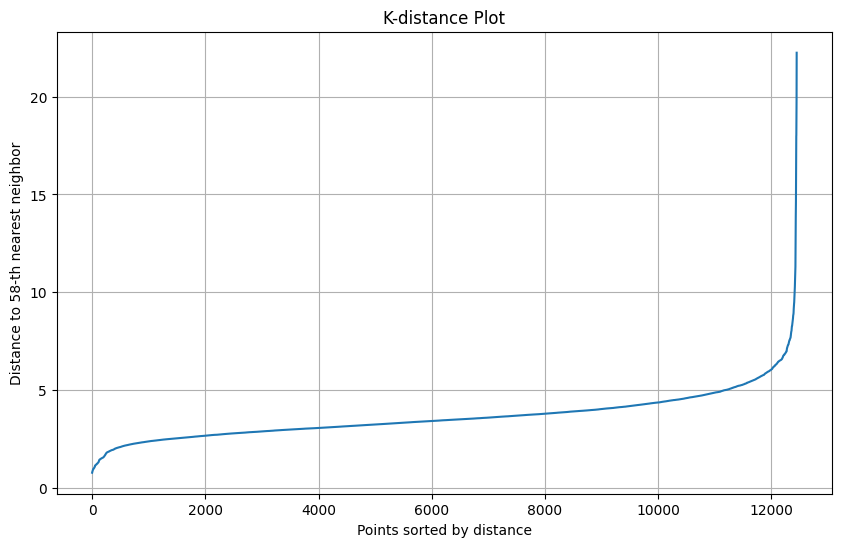

In [198]:
from sklearn.neighbors import NearestNeighbors

# setting min_samples for the DBSCAN => rule of thumb: two times of total features in the dataframe
min_samples = len(df_final.columns)*2  # Set your min_samples for DBSCAN

# Fit Nearest Neighbors
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(preprocessed_df)
distances, indices = nbrs.kneighbors(preprocessed_df)

# Get the distances to the k-th nearest neighbor (min_samples)
k_distance = distances[:, min_samples - 1]  # Selecting the distance to the min_samples-neighbor

# Sort the K-distance
k_distance_sorted = np.sort(k_distance)

# Plot the K-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distance_sorted)
plt.title('K-distance Plot')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {min_samples}-th nearest neighbor')
plt.grid(True)
plt.show()

#### The distance value at the point of boosting of the graph should be chosen for Epsilon 

In [199]:
eps = 7  # Maximum distance between two samples for them to be considered as in the same neighborhood chosen from graph

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(preprocessed_df)

# Add cluster labels to the original data
df_final['cluster'] = clusters

In [200]:
# Count clusters and noise points
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # -1 indicates noise
n_noise = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 4
Estimated number of noise points: 37


#### Tryin to understand the most significant columns considered in clustering => Fit a machine learning algorithm to classify clusters

In [201]:
X = preprocessed_df  # Features
y = df_final['cluster']  # Targets based on clustering

#Support Vector Classifier with rbf kernel to assess non-linear relationships
rf_model = SVC(kernel="rbf")
rf_model.fit(X, y)

#Feature Importances
feature_importance = permutation_importance(rf_model, X, y, n_repeats=10, random_state=45)

#creating a datadrame to assess the results
feature_names = X.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance.importances_mean})

#sort feature importances
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_df.head()

,Feature,Importance
22,host_has_profile_pic,0.031655
28,room_type_Shared room,0.015173
26,room_type_Hotel room,0.013944
12,price,0.001285
8,bathrooms,0.001092


#### Generated clusters
1. host has profile pic - room type Entire => cluster == 0, filter == "room_type_Entire home/apt"
3. host has profile pic - room type private => cluster == 0, filter == "room_type_Private room"
5. host has profile pic - room type shared => cluster == 2
6. host no pic - room type Entire and private => cluster == 1

In [202]:
#Merge ids back to join with sentiments
df_fin = pd.concat([ids, df_final], axis=1).dropna()
#Clear the noises
df_fin = df_fin[df_fin['cluster'] != -1]

In [206]:
df_fin.head()

,id,name_sent,desc_sent,days_as_host,host_in_NY,host_about,host_response_rate_int,host_acceptance_rate_int,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,instant_bookable,calculated_host_listings_count,private_bathroom,shared_bathroom,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cluster
0,572612125615500056,1,2,1505,1,0,100,94,1,2,1,0,1,1.0,1.0,1.0,40,45.0,30,100,336,6,1,2,0.0,1.0,0,0,1,0,0
1,13234457,1,2,5839,1,0,100,0,0,2,1,1,2,1.0,1.0,1.0,6,60.0,30,1125,311,2,0,1,1.0,0.0,1,0,0,0,0
2,760086536368275287,2,2,4823,1,74,100,0,0,1,1,1,4,2.0,2.0,2.0,53,495.0,30,365,154,8,0,1,2.0,0.0,1,0,0,0,0
3,1080524247229234431,2,2,3822,1,258,87,72,0,2,1,1,2,1.0,1.0,1.0,9,116.0,30,365,313,3,0,31,1.0,0.0,1,0,0,0,0
4,303264,2,2,4630,0,74,100,73,0,2,1,1,10,1.0,2.0,6.0,20,250.0,30,180,355,8,0,11,1.0,0.0,1,0,0,0,0


## Frequent item analysis

### Merge listings and sentiments

In [203]:
#Read the sentiment scores data generated by Georgios
df_sentiment = pd.read_csv("./NYtransREVnSCALE3.csv", header=[0], low_memory=False)
df_final_sentiment = df_sentiment[["listing_id", "scaled"]]
df_joined = pd.merge(df_final_sentiment, df_fin, left_on="listing_id", right_on="id", how="left")
df_joined = df_joined.dropna(subset=["id"])

In [204]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42613 entries, 0 to 76336
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   listing_id                      42613 non-null  int64  
 1   scaled                          42613 non-null  object 
 2   id                              42613 non-null  float64
 3   name_sent                       42613 non-null  float64
 4   desc_sent                       42613 non-null  float64
 5   days_as_host                    42613 non-null  float64
 6   host_in_NY                      42613 non-null  float64
 7   host_about                      42613 non-null  float64
 8   host_response_rate_int          42613 non-null  float64
 9   host_acceptance_rate_int        42613 non-null  float64
 10  host_is_superhost               42613 non-null  float64
 11  host_verifications              42613 non-null  float64
 12  host_has_profile_pic            42613

### First cluster

In [207]:
first_cluster_df = df_joined[(df_joined["cluster"] == 0) & (df_joined["room_type_Entire home/apt"] == 1)]

#### Converting all numericals to categorical to perform apriori algorithm

In [208]:
first_cluster_df['name_sent'] = first_cluster_df['name_sent'].replace({0: 'name_negative', 1: 'name_neutral', 2: 'name_positive'})
first_cluster_df['desc_sent'] = first_cluster_df['desc_sent'].replace({0: 'desc_negative', 1: 'desc_neutral', 2: 'desc_positive'})
first_cluster_df['days_as_host'] = pd.cut(first_cluster_df['days_as_host'], bins=[i*365 for i in range(20)], labels=[f"{i} years" for i in range(19)])
first_cluster_df['host_in_NY'] = first_cluster_df['name_sent'].replace({0: 'host_not_in_NY', 1: 'host_in_NY'})
first_cluster_df['host_about'] = pd.cut(first_cluster_df['host_about'], bins=[0,50,100,150,1000], labels=["very_short_about", "short_about", "moderate_about", "long_about"])
first_cluster_df['host_response_rate_int'] = pd.cut(first_cluster_df['host_response_rate_int'], bins=[0,25,50,75,100], labels=["very_low_response", "low_response", "moderate_response", "high_response"])
first_cluster_df['host_acceptance_rate_int'] = pd.cut(first_cluster_df['host_acceptance_rate_int'], bins=[0,25,50,75,100], labels=["very_low_acceptance", "low_acceptance", "moderate_acceptance", "high_acceptance"])
first_cluster_df['host_is_superhost'] = first_cluster_df['host_is_superhost'].replace({0: 'host_is_not_superhost', 1: 'host_is_superhost'})
first_cluster_df['host_verifications'] = first_cluster_df['host_verifications'].replace({0: 'no_verification', 1: '1_verification', 2: '2_verification', 3: 'all_verification'})
first_cluster_df['host_identity_verified'] = first_cluster_df['host_identity_verified'].replace({0: 'host_identity_not_verified', 1: 'host_identity_verified'})
first_cluster_df['accommodates'] = first_cluster_df['accommodates'].apply(lambda x: f"{x} accommodates")
first_cluster_df['bathrooms'] = first_cluster_df['bathrooms'].apply(lambda x: f"{x} bathrooms")
first_cluster_df['bedrooms'] = first_cluster_df['bedrooms'].apply(lambda x: f"{x} bedrooms")
first_cluster_df['beds'] = first_cluster_df['beds'].apply(lambda x: f"{x} beds")
first_cluster_df['amenities'] = first_cluster_df['amenities'].apply(lambda x: f"{x} amenities")
first_cluster_df['price'] = pd.cut(first_cluster_df['price'], bins=[0,50,100,150,200,250,10000], labels=["very_cheap", "cheap", "moderate", "somehow expensive", "expensive", "very expensive"])
first_cluster_df['minimum_nights'] = first_cluster_df['minimum_nights'].apply(lambda x: f"{x} min_nights")
first_cluster_df['maximum_nights'] = first_cluster_df['maximum_nights'].apply(lambda x: f"{x} max_nights")
first_cluster_df['availability_365'] = pd.cut(first_cluster_df['availability_365'], bins=[0,30,60,90,120,150,180,210,240,270,300,330,367], labels=[f"available_{i}_{i+1}_months" for i in range(12)])
first_cluster_df['number_of_reviews'] = pd.cut(first_cluster_df['number_of_reviews'], bins=[0,10,50,200,500,10000], labels=["very_low_number_of_rev", "low_number_of_rev", "moderate_number_of_rev", "high_of_rev", "very_high_number_of_rev"])
first_cluster_df['instant_bookable'] = first_cluster_df['instant_bookable'].replace({0: 'not_instant_bookable', 1: 'instant_bookable'})
first_cluster_df['calculated_host_listings_count'] = pd.cut(first_cluster_df['calculated_host_listings_count'], bins=[0,2,5,15,50,500], labels=["very_low_number_of_listings", "low_number_of_listings", "moderate_number_of_listings", "high_of_listings", "very_high_number_of_listings"])
first_cluster_df['private_bathroom'] = first_cluster_df['private_bathroom'].apply(lambda x: f"{x} private_bathroom")
first_cluster_df['shared_bathroom'] = first_cluster_df['shared_bathroom'].apply(lambda x: f"{x} shared_bathroom")

In [209]:
first_cluster_df = first_cluster_df.drop(columns=["listing_id", "id", "host_has_profile_pic", "room_type_Entire home/apt", "room_type_Hotel room", "room_type_Private room", "room_type_Shared room", "cluster"])

In [210]:
#Convert everything to string
first_cluster_df = first_cluster_df.astype(str)
first_cluster_df.head()

,scaled,name_sent,desc_sent,days_as_host,host_in_NY,host_about,host_response_rate_int,host_acceptance_rate_int,host_is_superhost,host_verifications,host_identity_verified,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,instant_bookable,calculated_host_listings_count,private_bathroom,shared_bathroom
0,VG,name_neutral,desc_positive,15 years,name_neutral,short_about,moderate_response,very_low_acceptance,host_is_not_superhost,all_verification,host_identity_verified,1.0 accommodates,1.0 bathrooms,0.0 bedrooms,1.0 beds,32.0 amenities,expensive,30.0 min_nights,1125.0 max_nights,available_8_9_months,low_number_of_rev,not_instant_bookable,low_number_of_listings,1.0 private_bathroom,0.0 shared_bathroom
1,VG,name_neutral,desc_positive,15 years,name_neutral,short_about,moderate_response,very_low_acceptance,host_is_not_superhost,all_verification,host_identity_verified,1.0 accommodates,1.0 bathrooms,0.0 bedrooms,1.0 beds,32.0 amenities,expensive,30.0 min_nights,1125.0 max_nights,available_8_9_months,low_number_of_rev,not_instant_bookable,low_number_of_listings,1.0 private_bathroom,0.0 shared_bathroom
2,VG,name_neutral,desc_positive,15 years,name_neutral,short_about,moderate_response,very_low_acceptance,host_is_not_superhost,all_verification,host_identity_verified,1.0 accommodates,1.0 bathrooms,0.0 bedrooms,1.0 beds,32.0 amenities,expensive,30.0 min_nights,1125.0 max_nights,available_8_9_months,low_number_of_rev,not_instant_bookable,low_number_of_listings,1.0 private_bathroom,0.0 shared_bathroom
3,VG,name_neutral,desc_positive,15 years,name_neutral,short_about,moderate_response,very_low_acceptance,host_is_not_superhost,all_verification,host_identity_verified,1.0 accommodates,1.0 bathrooms,0.0 bedrooms,1.0 beds,32.0 amenities,expensive,30.0 min_nights,1125.0 max_nights,available_8_9_months,low_number_of_rev,not_instant_bookable,low_number_of_listings,1.0 private_bathroom,0.0 shared_bathroom
4,VG,name_neutral,desc_positive,15 years,name_neutral,short_about,moderate_response,very_low_acceptance,host_is_not_superhost,all_verification,host_identity_verified,1.0 accommodates,1.0 bathrooms,0.0 bedrooms,1.0 beds,32.0 amenities,expensive,30.0 min_nights,1125.0 max_nights,available_8_9_months,low_number_of_rev,not_instant_bookable,low_number_of_listings,1.0 private_bathroom,0.0 shared_bathroom


#### Apriori and association rules

In [211]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [212]:
transactions = []

for _, row in first_cluster_df.iterrows():
    transactions.append(row.tolist())

In [213]:
te = TransactionEncoder()
te_data = te.fit(transactions).transform(transactions)
transact_df = pd.DataFrame(te_data, columns=te.columns_)

# Apriori algorithm with minimum support with 0.5 
#meaning just consider the items that have been included at least half of the transactions
frequent_itemsets = apriori(transact_df, min_support=0.5, use_colnames=True)

In [219]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.01, num_itemsets=int(frequent_itemsets.count().support))

In [221]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(1.0 bedrooms),(1.0 bathrooms),0.629919,0.922742,0.609914,0.968241,1.049309,1.0,0.028661,2.432640,0.126977,0.646954,0.588924,0.814610
1,(1.0 bathrooms),(1.0 bedrooms),0.922742,0.629919,0.609914,0.660980,1.049309,1.0,0.028661,1.091619,0.608241,0.646954,0.083929,0.814610
2,(1.0 bathrooms),(1.0 private_bathroom),0.922742,0.922742,0.922742,1.000000,1.083727,1.0,0.071289,inf,1.000000,1.000000,1.000000,1.000000
3,(1.0 private_bathroom),(1.0 bathrooms),0.922742,0.922742,0.922742,1.000000,1.083727,1.0,0.071289,inf,1.000000,1.000000,1.000000,1.000000
4,(2.0 accommodates),(1.0 bathrooms),0.530219,0.922742,0.509698,0.961297,1.041784,1.0,0.020443,1.996191,0.085375,0.540357,0.499046,0.756835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37579,(not_instant_bookable),"(desc_positive, host_identity_verified, high_r...",0.904891,0.567841,0.520755,0.575489,1.013469,1.0,0.006921,1.018017,0.139734,0.547025,0.017698,0.746284
37580,(host_identity_verified),"(desc_positive, not_instant_bookable, high_res...",0.934033,0.550834,0.520755,0.557534,1.012164,1.0,0.006258,1.015143,0.182174,0.540140,0.014917,0.751464
37581,(very_low_number_of_listings),"(desc_positive, not_instant_bookable, host_ide...",0.823979,0.617972,0.520755,0.632001,1.022701,1.0,0.011559,1.038121,0.126105,0.565304,0.036722,0.737342
37582,(1.0 private_bathroom),"(desc_positive, not_instant_bookable, host_ide...",0.922742,0.520755,0.520755,0.564356,1.083727,1.0,0.040233,1.100085,1.000000,0.564356,0.090979,0.782178


In [222]:
rules[(rules["consequents"] == frozenset({'VG'})) & (rules["lift"] >= 1.011)]["antecedents"].unique()

array([frozenset({'very_low_number_of_listings', '30.0 min_nights', 'high_response'}),
       frozenset({'very_low_number_of_listings', '30.0 min_nights', '0.0 shared_bathroom', 'high_response'})],
      dtype=object)

#### We can say that if customers rent an Entire home that have private bathroom (0 shared bathroom) for at least 30 days and get high response from the host, the probability of leaving positive feedback increases :)

### Second cluster (will continue)

In [ ]:
first_cluster_df = df_joined[(df_joined["cluster"] == 0) & (df_joined["room_type_Entire home/apt"] == 1)]